# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [1]:
#PLEASE RUN THIS CELL
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [3]:
#your code here
train_df = pd.read_csv("../data/dataset_2_train.csv");
test_df = pd.read_csv("../data/dataset_2_test.csv");
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
district             967 non-null int64
urban                967 non-null int64
living.children      967 non-null int64
age_mean             967 non-null float64
contraceptive_use    967 non-null int64
dtypes: float64(1), int64(4)
memory usage: 37.9 KB


,district,urban,living.children,age_mean,contraceptive_use
count,967.000000,967.000000,967.000000,967.000000,967.000000
mean,29.680455,0.307135,2.591520,-0.310626,0.389866
std,17.713976,0.461545,1.248457,8.995747,0.487972
min,1.000000,0.000000,1.000000,-13.560000,0.000000
25%,14.000000,0.000000,1.000000,-7.560000,0.000000
50%,29.000000,0.000000,3.000000,-1.559900,0.000000
75%,46.000000,1.000000,4.000000,6.440000,1.000000
max,61.000000,1.000000,4.000000,19.440000,1.000000


In [4]:
train_df['district'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 55, 56, 57, 58, 59, 60, 61])

In [5]:
train_df['district'].replace({61:54, 60:0}, inplace=True)
train_df.rename(columns = {"living.children":"living_children"}, inplace = True) 
test_df['district'].replace({61:54, 60:0}, inplace=True)
test_df.rename(columns = {"living.children":"living_children"}, inplace = True) 

In [6]:
train_df['district'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [7]:
train_df.head()

,district,urban,living_children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

The urban mean is 0.30713547052740436
The living_children mean is 2.591520165460186
The age_mean mean is  -0.31062595656670683
The current contraceptive_use mean is 0.38986556359875907
The calculated contraceptive_use mean is 0.4700359482354283
The new contraceptive_use mean is 0.4705274043433299


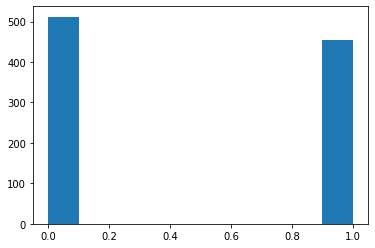

In [10]:
#your code here
np.random.seed(109) #use this seed tto generate the same results

print('The urban mean is', train_df['urban'].mean())
print('The living_children mean is', train_df['living_children'].mean())
print('The age_mean mean is ', train_df['age_mean'].mean())
print('The current contraceptive_use mean is', train_df['contraceptive_use'].mean())
print('The calculated contraceptive_use mean is', expit(2 + 4*.34 + -3*1 + -2*.24))

alpha, sigma = 2, 1
beta = [4, -3, -2]

colNames = ('district', 'beta0', 'urban', 'living_children', 'age_mean', 'contraceptive_use')
sim_df = pd.DataFrame(columns = colNames)

for i in np.unique(test_df['district']):
    beta = np.random.normal(alpha, sigma , 1)
    #u_mean = np.mean(test_df['urban'][test_df['district'] == i]) # replaced with calculated mean above
    #l_mean = np.mean(test_df['living_children'][test_df['district'] == i]) # replaced with calculated mean above
    l_sd = np.std(test_df['living_children'][test_df['district'] == i])
    #a_mean = np.mean(test_df['age_mean'][test_df['district'] == i]) # replaced with calculated mean above
    a_sd = np.std(test_df['age_mean'][test_df['district'] == i])
    for j in test_df[test_df['district'] == i].iterrows():
        temp_df = pd.DataFrame(columns = colNames)
        temp_df['district'] = [i]
        temp_df['beta0'] = beta
        temp_df['urban'] = np.random.binomial(1, .34, size=1)
        temp_df['living_children'] = np.random.normal(1.21, l_sd, size=1) # adjusted to generated .47 contraceptive_use mean
        temp_df['age_mean'] = np.random.normal(.24, a_sd, size=1)
        sim_df = sim_df.append(temp_df)

sim_df['district'] = sim_df['district'].astype(int)
sim_df['urban'] = sim_df['urban'].astype(int)

sim_df['contraceptive_use'] = np.round(expit(np.asfarray(sim_df['beta0'] + 4*sim_df['urban'] + -3*sim_df['living_children'] + -2*sim_df['age_mean'])))

sim_df['contraceptive_use'] = sim_df['contraceptive_use'].astype(int)

print('The new contraceptive_use mean is',np.mean(sim_df['contraceptive_use']))

plt.hist(sim_df['contraceptive_use'])
plt.show()


##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

Note: It is wise to take advantage of a model's built-in `summary` method to inspect it after fitting

In [25]:
#your code here

with pm.Model() as contraceptive_model:
    mu = pm.Normal('mu', mu=0)
    sigma = pm.Normal('sigma', sd=1)
    
    beta0 = pm.Normal('beta0', mu=mu, sigma=sigma, shape=len(np.unique(sim_df['district'])))[sim_df['district']]
    beta1 = pm.Normal('beta1', mu=0)
    beta2 = pm.Normal('beta2', mu=0)
    beta3 = pm.Normal('beta3', mu=0)
    
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(beta0 + beta1*sim_df['urban'] + beta2*sim_df['living_children'] + beta3*sim_df['age_mean']))
    
    obs = pm.Bernoulli('obs', p=p_i, shape=len(sim_df), observed=sim_df['contraceptive_use'])
    
    trace = pm.sample(1500, tune=1500, target_accept=0.95)
    
pm.summary(trace, var_names=['mu', 'sigma', 'beta0', 'beta1', 'beta2', 'beta3'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta3, beta2, beta1, beta0, sigma, mu]
Sampling 2 chains, 6 divergences: 100%|██████████| 6000/6000 [04:10<00:00, 23.96draws/s]
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8530107342422916, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does 

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,2.311,0.393,1.665,3.097,0.049,0.035,64.0,62.0,68.0,78.0,1.01
sigma,0.323,0.188,0.075,0.649,0.027,0.019,50.0,50.0,43.0,146.0,1.06
beta0[0],2.280,0.511,1.319,3.205,0.048,0.035,112.0,105.0,112.0,277.0,1.01
beta0[1],2.300,0.504,1.358,3.255,0.048,0.035,110.0,105.0,111.0,390.0,1.01
beta0[2],2.313,0.527,1.380,3.301,0.050,0.037,111.0,104.0,109.0,336.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
beta0[58],2.295,0.551,1.286,3.329,0.050,0.037,122.0,114.0,118.0,339.0,1.01
beta0[59],2.344,0.537,1.355,3.321,0.050,0.035,118.0,118.0,113.0,379.0,1.01
beta1,3.492,0.509,2.584,4.448,0.023,0.016,496.0,496.0,494.0,1197.0,1.00
beta2,-3.147,0.340,-3.767,-2.509,0.036,0.025,92.0,90.0,94.0,263.0,1.01


##### **A4**

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89d031d490>,
      dtype=object)

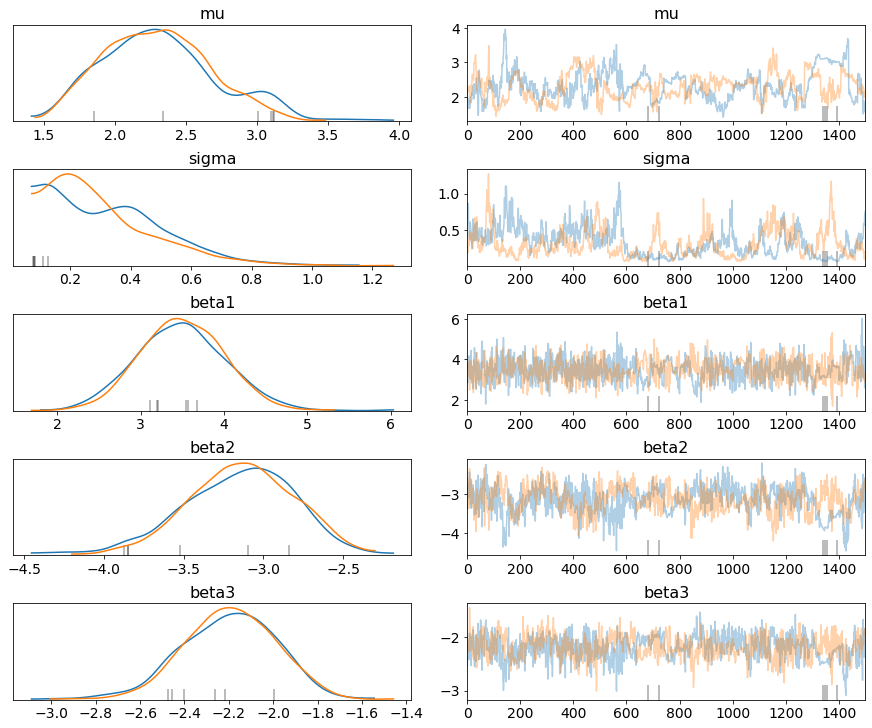

In [26]:
#your code here
pm.traceplot(trace, var_names=('mu', 'sigma', 'beta1', 'beta2', 'beta3'))


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f89ca897310>,
      dtype=object)

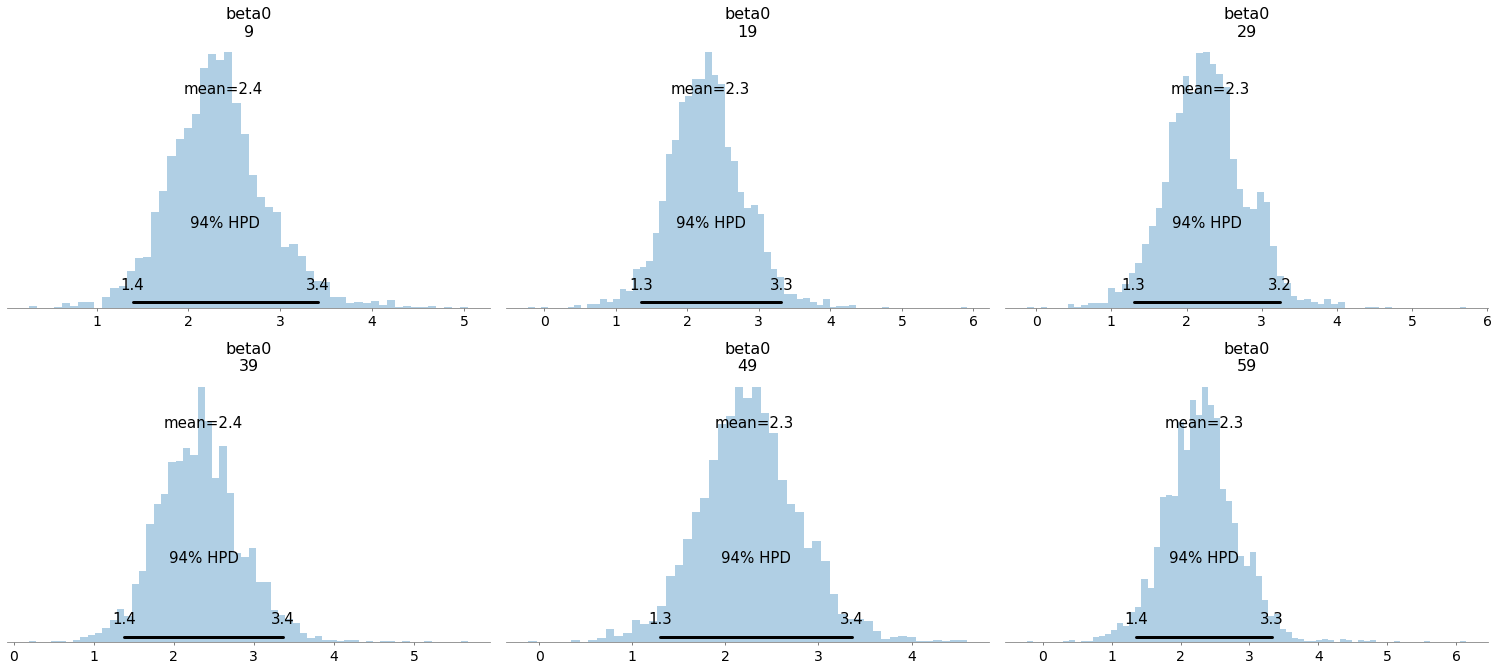

In [27]:
#your code here
#pm.plot_posterior(trace, var_names=('beta0'))
pm.plot_posterior(trace, var_names='beta0', coords={'beta0_dim_0': [9, 19, 29, 39, 49, 59]}, kind='hist')


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(<Figure size 1440x216 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f89d1ab8990>],
       dtype=object))

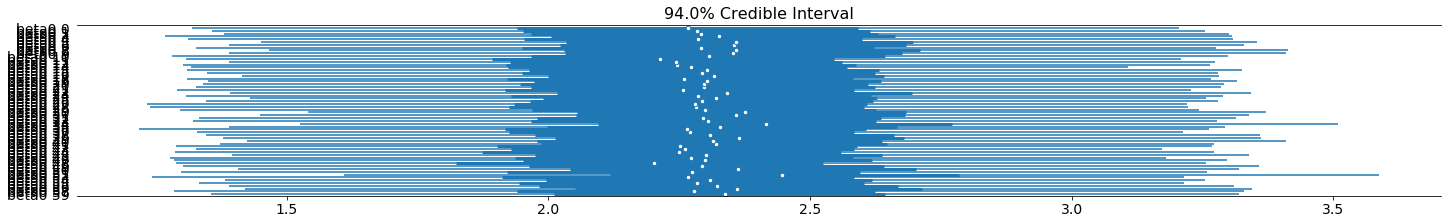

In [28]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta0'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 3))


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [43]:
#your code here
#with pm.Model() as contraceptive_model:
with contraceptive_model:
    #mu = pm.Normal('mu', mu=0, tau=10000)
    #sigma = pm.Gamma('sigma', alpha=.001, beta=.001)
    
    #beta0 = pm.Normal('beta0', mu=0, sigma=sigma, shape=len(np.unique(train_df['district'])))[train_df['district']]
    #beta1 = pm.Normal('beta1', mu=0, tau=10000)
    #beta2 = pm.Normal('beta2', mu=0, tau=10000)
    #beta3 = pm.Normal('beta3', mu=0, tau=10000)
    
    pi = pm.Deterministic('$Pi$', pm.math.invlogit(beta0 + beta1*train_df['urban'] + beta2*train_df['living_children'] + beta3*train_df['age_mean']))
    
    obs_cu = pm.Bernoulli('obs_cu', p=pi, shape=len(train_df), observed=train_df['contraceptive_use'])

    trace = pm.sample(1500, tune=1000, target_accept=0.95)

    print(trace.varnames)    
    print('DONE')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta3, beta2, beta1, beta0, sigma1, sigma0, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:43<00:00, 48.27draws/s]


['mu', 'sigma0_log__', 'sigma1_log__', 'beta0', 'beta1', 'beta2', 'beta3', 'sigma0', 'sigma1', '$P_i$', '$P_i$', '$P_i$', '$P__i$', '$P__i$', '$P__i$', '$Pi$']
DONE


In [45]:
pm.summary(trace, var_names=['mu', 'sigma0', 'sigma1', 'beta0', 'beta1', 'beta2', 'beta3'])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.000,0.010,-0.019,0.019,0.000,0.000,7459.0,966.0,7450.0,1919.0,1.0
sigma0,1.230,0.150,0.962,1.514,0.003,0.002,2591.0,2533.0,2665.0,2639.0,1.0
sigma1,1.736,0.312,1.184,2.312,0.011,0.008,816.0,801.0,847.0,1335.0,1.0
beta0[0],-2.468,0.613,-3.597,-1.346,0.011,0.008,3045.0,2891.0,3103.0,2371.0,1.0
beta0[1],-1.557,0.333,-2.172,-0.956,0.006,0.004,3571.0,3146.0,3665.0,2238.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta1[57],-0.940,1.387,-3.389,1.707,0.022,0.024,4042.0,1660.0,4597.0,1955.0,1.0
beta1[58],-0.646,0.525,-1.632,0.343,0.008,0.007,4434.0,3102.0,4425.0,2593.0,1.0
beta1[59],0.036,1.820,-3.483,3.373,0.024,0.038,5985.0,1172.0,6059.0,2000.0,1.0
beta2,0.007,0.009,-0.011,0.024,0.000,0.000,4228.0,2341.0,4214.0,2370.0,1.0


##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89d3e3e3d0>,
      dtype=object)

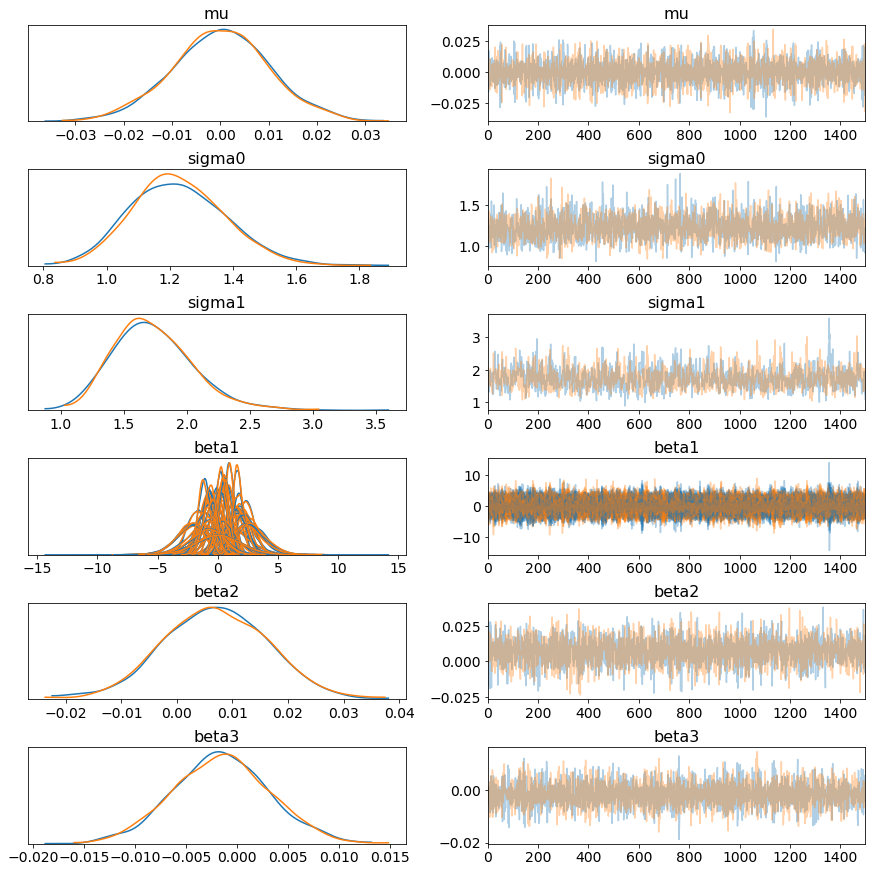

In [46]:
#your code here
pm.traceplot(trace, var_names=('mu', 'sigma0', 'sigma1', 'beta1', 'beta2', 'beta3'))


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

In [47]:
#your code here
beta0_sum = pm.summary(trace, var_names=['beta0'])
beta0_sum[(beta0_sum['mean']==beta0_sum['mean'].min()) | (beta0_sum['mean']==beta0_sum['mean'].max())]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[11],-2.942,0.691,-4.209,-1.677,0.011,0.009,4152.0,3238.0,4823.0,2091.0,1.0
beta0[34],0.916,0.327,0.311,1.550,0.005,0.004,4676.0,3501.0,4733.0,1930.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f89d5898e90>,
      dtype=object)

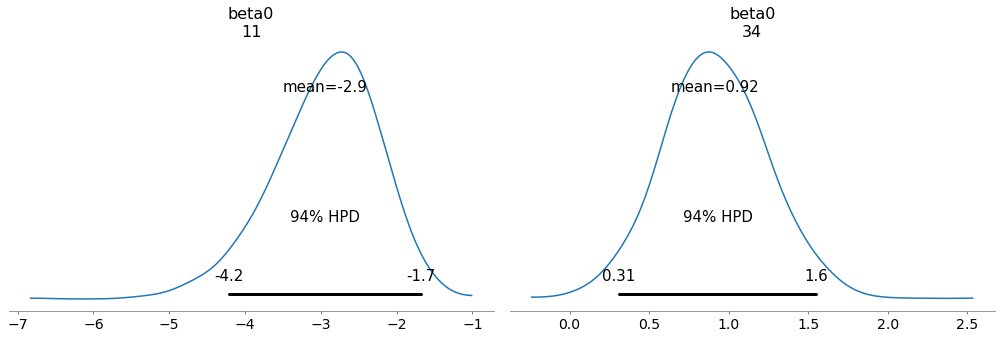

In [48]:
pm.plots.plot_posterior(trace, var_names = 'beta0', coords={'beta0_dim_0': [11, 34]})


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f89d561c250>,
      dtype=object)

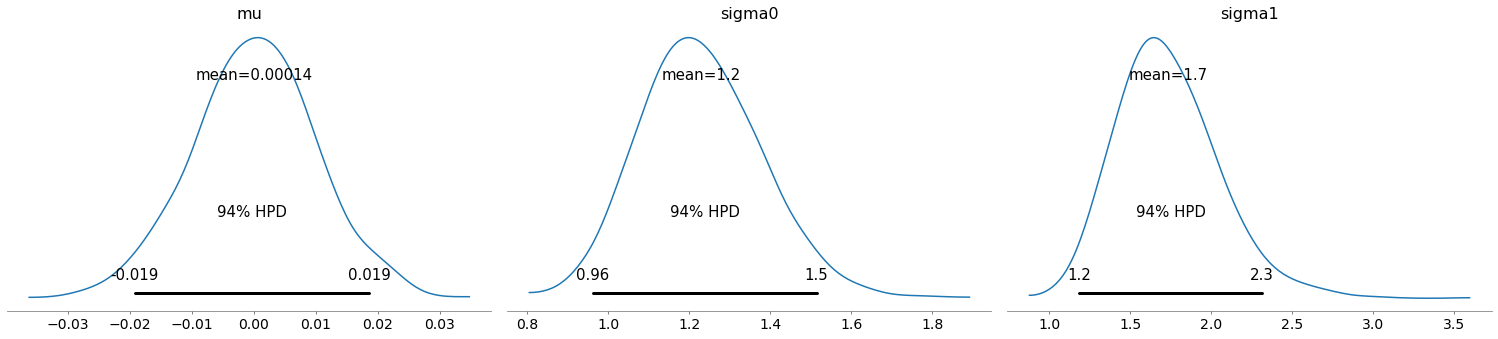

In [49]:
#your code here
pm.plot_posterior(trace, var_names=('mu', 'sigma0', 'sigma1'))


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [14]:
#your code here
with pm.Model() as contraceptive_model:
    mu = pm.Normal('mu', mu=0, tau=10000)
    
    sigma0 = pm.Gamma('sigma0', alpha=.001, beta=.001)
    sigma1 = pm.Gamma('sigma1', alpha=.001, beta=.001)
    sigma2 = pm.Gamma('sigma2', alpha=.001, beta=.001)
    sigma3 = pm.Gamma('sigma3', alpha=.001, beta=.001)
    
    beta0 = pm.Normal('beta0', mu=mu, sigma=sigma0, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta1 = pm.Normal('beta1', mu=0, sigma=sigma1, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta2 = pm.Normal('beta2', mu=0, sigma=sigma2, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta3 = pm.Normal('beta3', mu=0, sigma=sigma3, shape=len(np.unique(train_df['district'])))[train_df['district']]
    
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(beta0 + beta1*train_df['urban'] + beta2*train_df['living_children'] + beta3*train_df['age_mean']))
    
    obs = pm.Bernoulli('obs', p=p_i, shape=len(train_df), observed=train_df['contraceptive_use'])
    
    trace = pm.sample(2500, tune=500, target_accept=0.99)
    
    print(trace.varnames)    
    print('DONE')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta3, beta2, beta1, beta0, sigma3, sigma2, sigma1, sigma0, mu]
Sampling 2 chains, 1 divergences: 100%|██████████| 6000/6000 [32:43<00:00,  3.06draws/s] 
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in a

['mu', 'sigma0_log__', 'sigma1_log__', 'sigma2_log__', 'sigma3_log__', 'beta0', 'beta1', 'beta2', 'beta3', 'sigma0', 'sigma1', 'sigma2', 'sigma3', '$P_i$']
DONE


In [15]:
pm.summary(trace, var_names=['mu', 'sigma0', 'sigma1', 'sigma2', 'sigma3'])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.003,0.010,-0.022,0.015,0.000,0.000,5431.0,2038.0,5431.0,2975.0,1.00
sigma0,0.778,0.137,0.517,1.027,0.006,0.004,488.0,488.0,483.0,1951.0,1.01
sigma1,0.301,0.295,0.003,0.845,0.089,0.065,11.0,11.0,5.0,41.0,1.35
sigma2,0.052,0.048,0.002,0.144,0.010,0.007,24.0,24.0,19.0,51.0,1.07
sigma3,0.002,0.004,0.000,0.010,0.002,0.001,5.0,5.0,3.0,22.0,1.79


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53bb6231d0>,
      dtype=object)

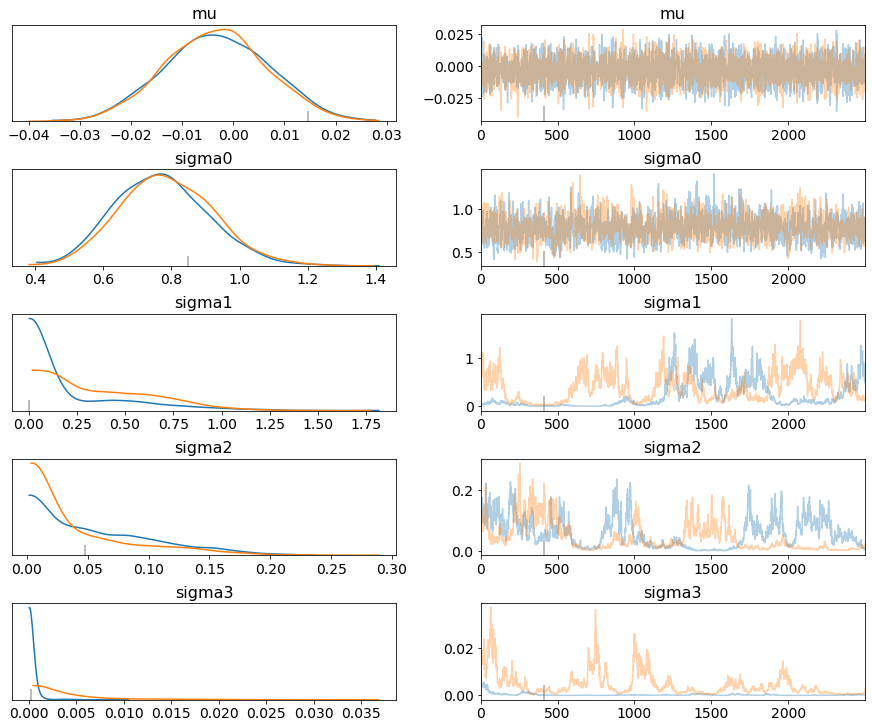

In [16]:
pm.traceplot(trace, var_names=('mu', 'sigma0', 'sigma1', 'sigma2', 'sigma3'))


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(<Figure size 1440x216 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53cba14150>],
       dtype=object))

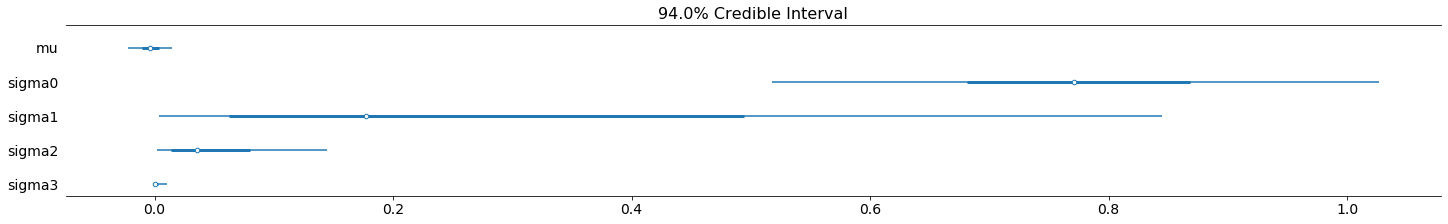

In [17]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['mu', 'sigma0', 'sigma1', 'sigma2', 'sigma3'],
               combined=True,
               ridgeplot_overlap=5,
               figsize=(20, 3))

In [18]:
beta0_sum = pm.summary(trace, var_names=['beta0'])
beta0_sum[(beta0_sum['mean']==beta0_sum['mean'].min()) | (beta0_sum['mean']==beta0_sum['mean'].max())]


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[11],-1.377,0.608,-2.512,-0.248,0.016,0.011,1526.0,1526.0,1623.0,2907.0,1.0
beta0[56],0.737,0.414,-0.047,1.538,0.006,0.005,4352.0,3929.0,4348.0,3415.0,1.0


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53c2774c10>,
      dtype=object)

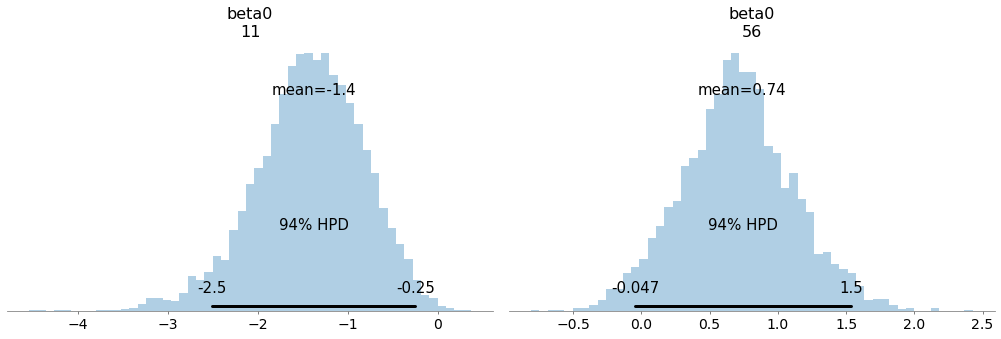

In [19]:
pm.plot_posterior(trace, var_names='beta0', coords={'beta0_dim_0': [11, 56]}, kind='hist')


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(<Figure size 1440x216 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53c27c41d0>],
       dtype=object))

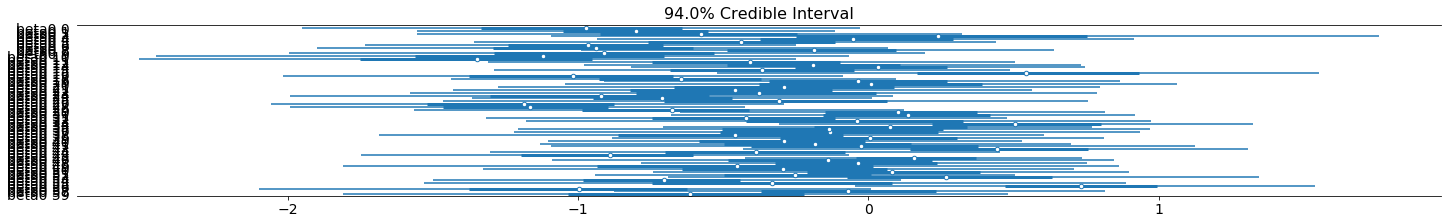

In [20]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta0'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 3))


In [21]:
beta1_sum = pm.summary(trace, var_names=['beta1'])
beta1_sum[(beta1_sum['mean']==beta1_sum['mean'].min()) | (beta1_sum['mean']==beta1_sum['mean'].max())]


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta1[14],0.280,0.420,-0.239,1.183,0.084,0.060,25.0,25.0,24.0,269.0,1.08
beta1[52],-0.197,0.394,-1.156,0.310,0.055,0.039,51.0,51.0,55.0,420.0,1.09


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53c39ab3d0>,
      dtype=object)

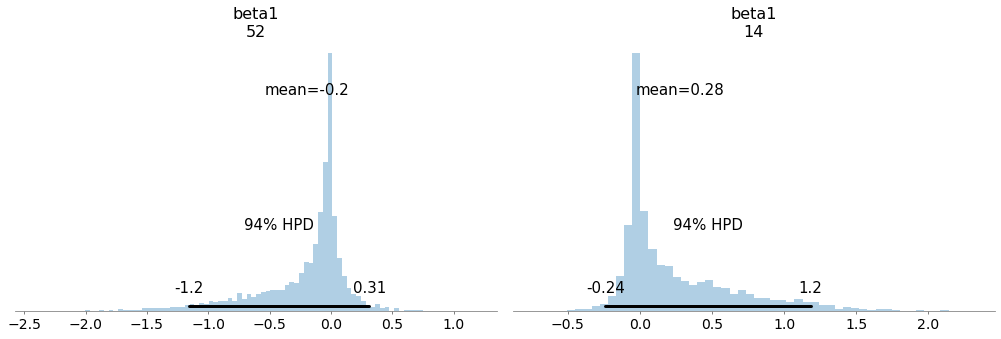

In [22]:
pm.plot_posterior(trace, var_names='beta1', coords={'beta1_dim_0': [52, 14]}, kind='hist')


(<Figure size 1440x216 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53c45156d0>],
       dtype=object))

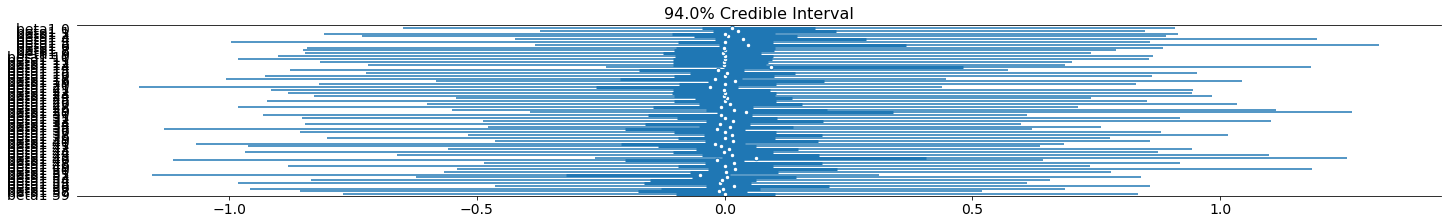

In [23]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta1'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 3))


In [24]:
beta2_sum = pm.summary(trace, var_names=['beta2'])
beta2_sum[(beta2_sum['mean']==beta2_sum['mean'].min()) | (beta2_sum['mean']==beta2_sum['mean'].max())]


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta2[30],0.034,0.079,-0.072,0.217,0.008,0.006,100.0,100.0,135.0,402.0,1.03
beta2[54],-0.035,0.080,-0.211,0.076,0.008,0.006,95.0,95.0,132.0,217.0,1.03


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53d4f55e10>,
      dtype=object)

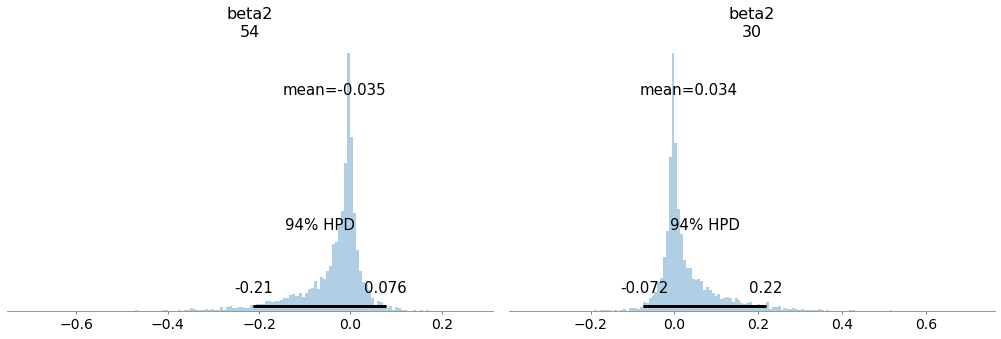

In [25]:
pm.plot_posterior(trace, var_names='beta2', coords={'beta2_dim_0': [54, 30]}, kind='hist')


(<Figure size 1440x216 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53c36a3f50>],
       dtype=object))

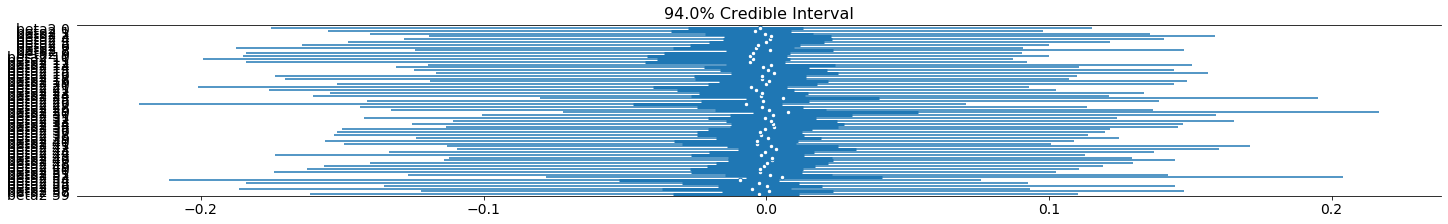

In [26]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta2'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 3))


In [27]:
beta3_sum = pm.summary(trace, var_names=['beta3'])
beta3_sum[(beta3_sum['mean']==beta3_sum['mean'].min()) | (beta3_sum['mean']==beta3_sum['mean'].max())]


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta3[18],-0.001,0.005,-0.010,0.007,0.001,0.001,99.0,35.0,3230.0,22.0,1.51
beta3[21],-0.001,0.005,-0.008,0.007,0.000,0.001,134.0,37.0,1277.0,28.0,1.47
beta3[25],0.001,0.006,-0.008,0.009,0.001,0.001,53.0,53.0,629.0,23.0,1.50
beta3[29],0.001,0.005,-0.006,0.009,0.000,0.000,364.0,125.0,2983.0,27.0,1.49
beta3[51],-0.001,0.005,-0.009,0.007,0.000,0.001,719.0,47.0,4867.0,25.0,1.49
beta3[52],0.001,0.005,-0.006,0.010,0.000,0.000,410.0,65.0,3185.0,25.0,1.52
beta3[54],-0.001,0.005,-0.009,0.006,0.001,0.000,83.0,57.0,1469.0,26.0,1.49


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53c27890d0>,
      dtype=object)

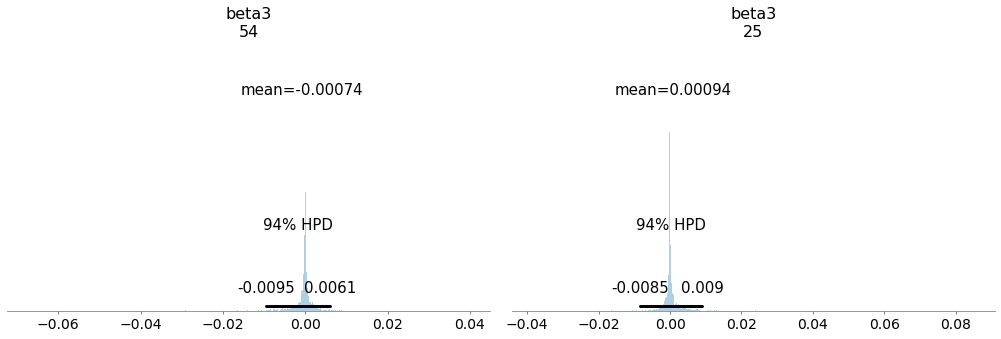

In [28]:
pm.plot_posterior(trace, var_names='beta3', coords={'beta3_dim_0': [54, 25]}, kind='hist')


(<Figure size 1440x216 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f53c0037f50>],
       dtype=object))

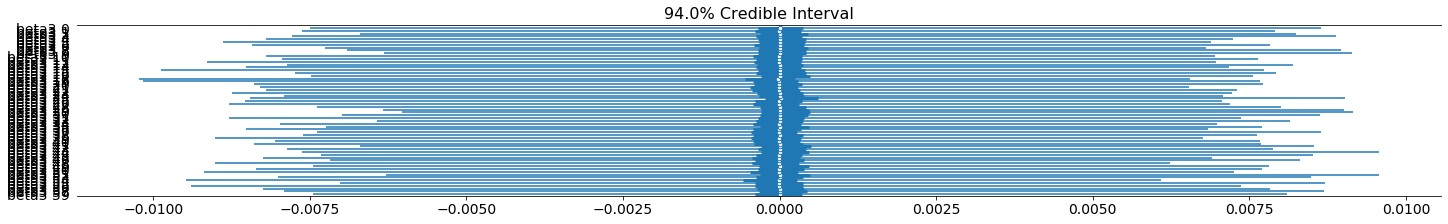

In [29]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta3'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 3))


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [36]:
train_df[['district','urban','living_children','age_mean']]

,district,urban,living_children,age_mean
0,35,0,4,2.4400
1,22,0,2,-1.5599
2,29,0,2,-8.5599
3,5,0,3,-4.5599
4,34,1,4,8.4400
...,...,...,...,...
962,45,0,2,-6.5599
963,27,0,2,-4.5599
964,35,0,4,-8.5599
965,7,0,3,1.4400


In [35]:
#your code here
with pm.Model() as contraceptive_model:
    #data = pm.Data('data', train_df[['district','urban','living_children','age_mean']])
    district = pm.Data('district', train_df['district'])
    urban = pm.Data('urban', train_df['urban'])
    living_children = pm.Data('living_children', train_df['living_children'])
    age_mean = pm.Data('age_mean', train_df['age_mean'])
    contraceptive_use = pm.Data('contraceptive_use', train_df['contraceptive_use'])
    
    mu = pm.Normal('mu', mu=0, tau=10000)
    
    sigma0 = pm.Gamma('sigma0', alpha=.001, beta=.001)
    #sigma1 = pm.Gamma('sigma1', alpha=.001, beta=.001)
    #sigma2 = pm.Gamma('sigma2', alpha=.001, beta=.001)
    #sigma3 = pm.Gamma('sigma3', alpha=.001, beta=.001)
    
    beta0 = pm.Normal('beta0', mu=0, sigma=sigma0, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta1 = pm.Normal('beta1', mu=0, tau=10000)#, sigma=sigma1, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta2 = pm.Normal('beta2', mu=0, tau=10000)#, sigma=sigma2, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta3 = pm.Normal('beta3', mu=0, tau=10000)#, sigma=sigma3, shape=len(np.unique(train_df['district'])))[train_df['district']]
    
    #p_i = pm.Deterministic('$P_i$', pm.math.invlogit(beta0 + beta1*train_input['urban'] + beta2*train_input['living_children'] + beta3*train_input['age_mean']))
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(beta0 + beta1*urban + beta2*living_children + beta3*age_mean))
    
    obs = pm.Bernoulli('obs', p=p_i, shape=len(train_df['contraceptive_use']), observed=contraceptive_use)
    
    trace = pm.sample(1500, tune=1500, target_accept=0.95)
    
    print(trace.varnames)    
    print('DONE')


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


AttributeError: 'TensorSharedVariable' object has no attribute 'urban'

In [ ]:
ppc_cu = pm.sample_posterior_predictive(trace, samples=500, model=contraceptive_model)


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>